In [1]:
import os

import numpy as np
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import f1_score, jaccard_score, confusion_matrix, recall_score
from skimage.morphology import disk, erosion, dilation
from skimage.measure import regionprops, label

In [2]:
def read_image(path):
    """Reads image from path and returns image array"""
    img = skimage.io.imread(path, as_gray=True)

    return np.expand_dims(img, axis=2)

def postprocessing(mask):
    '''This function enabels post processing based on binary mask.
    This consists of selecting the largest object (one_object) and a closing
    operation to fill the holes (closing)
    Input: binary mask
    Returns: Post processing mask (0,1)
    ''' 
    labels_mask = label(mask)                       
    regions = regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
      for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    mask = labels_mask
    
    if np.max(mask) == 255:
      mask = mask/255
    im_flood_fill = mask.copy()
    h, w = mask.shape[:2]
    overlay = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv2.floodFill(im_flood_fill, overlay, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    mask_out = mask | im_flood_fill_inv
    mask_out = mask_out/255
    return mask_out

IMG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Raw_data\images/"
IMG_TIMELAPSE_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Processed_data\timelapse_data/"
MASK_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Raw_data\mask/"
MODEL_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Programming\Debugging\experiment_009/"
OUTPUT_PATH =  r"C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_selection/"


In [3]:
def build_unet_model(input_height, input_width, input_channels):
    # Define input layer
    inputs = tf.keras.layers.Input((input_height, input_width, input_channels))

    # Normalize input data
    normalized_inputs = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Down sampling path
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    pool5 = tf.keras.layers.MaxPooling2D((2, 2))(conv5)
    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool5)

    # Upsampling path
    up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv5])
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat7)
    up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = tf.keras.layers.concatenate([up8, conv4])
    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat8)
    up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = tf.keras.layers.concatenate([up9, conv3])
    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat9)
    up10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9)
    concat10 = tf.keras.layers.concatenate([up10, conv2])
    conv10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat10)
    up11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv10)
    concat11 = tf.keras.layers.concatenate([up11, conv1], axis=3)
    conv11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat11)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv11)

    # Build the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [4]:
# load trained model    
model = build_unet_model(input_height=800, input_width=800, input_channels=1)
model.load_weights(MODEL_PATH + 'complete_model_' + '1' + '.h5')

folder = "E32"

# if int(folder[1:]) not in test_ids:
#     continue

test_fn_timelapse = sorted([file for file in os.listdir(IMG_TIMELAPSE_PATH + folder)])

# Full timelapse data:
test_images_timelapse = np.array([read_image(IMG_TIMELAPSE_PATH + folder + '/' + file) for file in test_fn_timelapse])

# Sample images:
idx = np.round(np.linspace(0, len(test_images_timelapse) - 1, 10)).astype(int)
test_images_timelapse_sample = test_images_timelapse[idx]


# # Predictions:
test_predictions = model.predict(test_images_timelapse_sample, batch_size=8)

# # Post processing:
test_predictions_post = np.array([postprocessing(test_predictions[i, :, :, 0] > 0.5) for i in range(test_predictions.shape[0])])

2/2 [==============================] - 22s 6s/step


In [5]:
test_predictions_post.shape

(10, 800, 800)

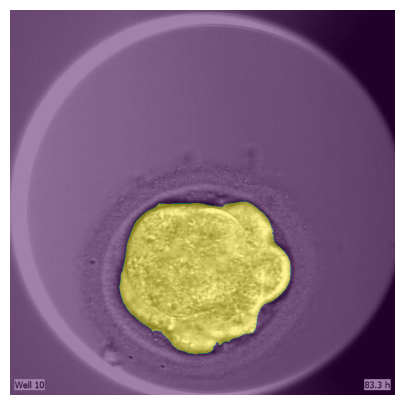

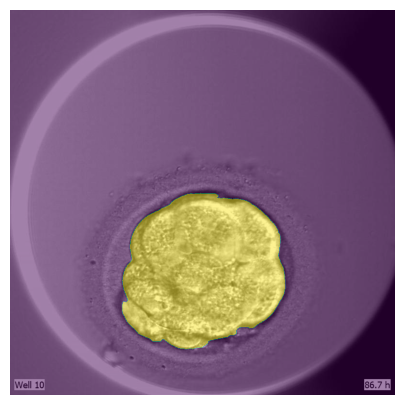

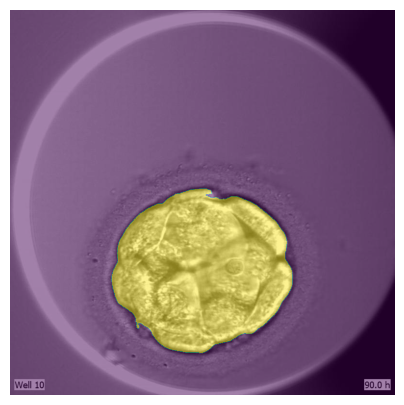

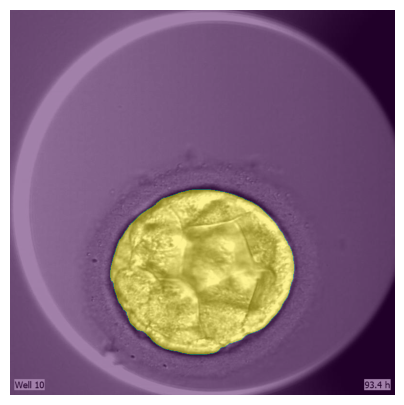

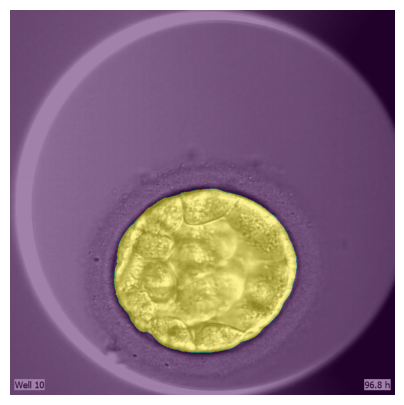

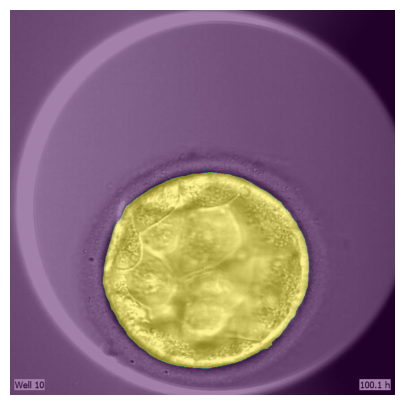

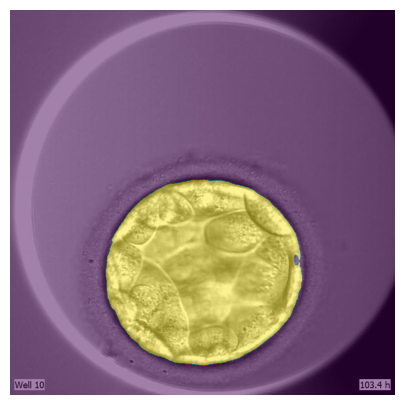

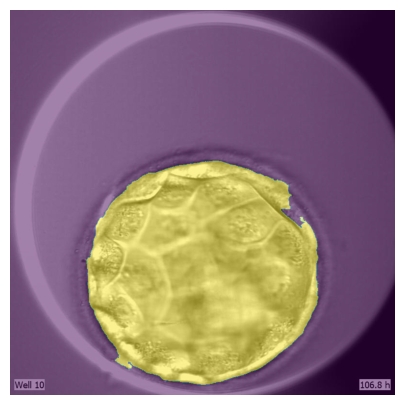

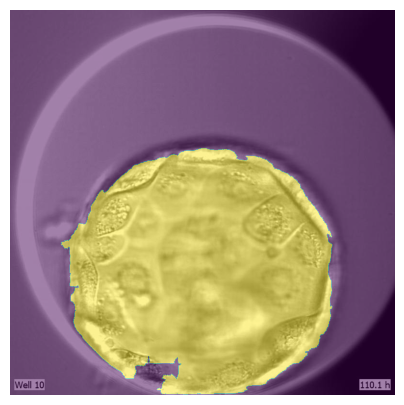

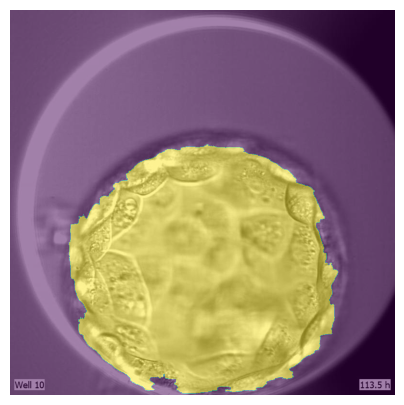

In [6]:
# plot all sampled images and predictions overlayed in alpha channel:
for i in range(len(test_images_timelapse_sample)):
    plt.figure(figsize=(5, 5))
    plt.imshow(test_images_timelapse_sample[i, :, :, 0], cmap='gray')
    plt.imshow(test_predictions_post[i,], alpha=0.5)
    plt.axis('off')

In [7]:
smooth_image = test_predictions_post[6]
ragged_image = test_predictions_post[9]

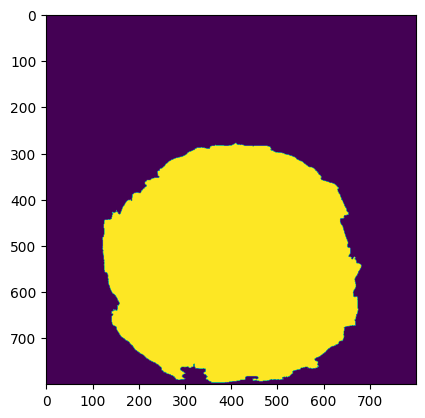

In [8]:
plt.imshow(ragged_image)

Text(0.5, 1.0, 'Difference')

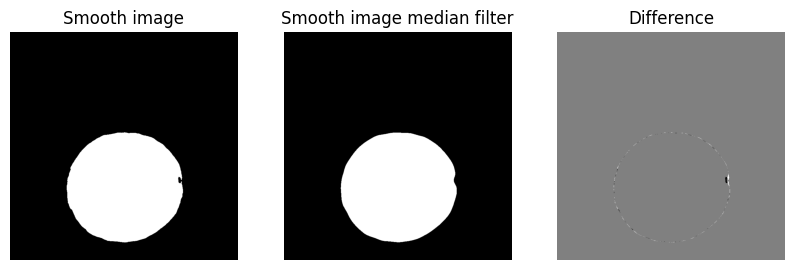

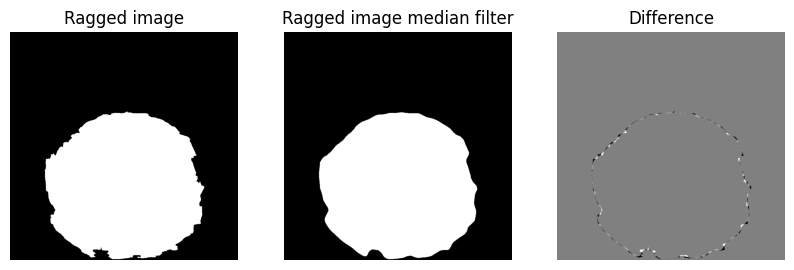

In [9]:
# median filter smooth_image and plot result next to original
smooth_image_median = cv2.medianBlur((smooth_image*255).astype('uint8'), 27) // 255

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(smooth_image, cmap='gray')
plt.axis('off')
plt.title('Smooth image')
plt.subplot(1, 3, 2)
plt.imshow(smooth_image_median, cmap='gray')
plt.axis('off')
plt.title('Smooth image median filter')
plt.subplot(1, 3, 3)
plt.imshow(smooth_image-smooth_image_median, cmap='gray')
plt.axis('off')
plt.title('Difference')

# median filter ragged_image and plot result next to original
ragged_image_median = cv2.medianBlur((ragged_image*255).astype('uint8'), 27) // 255

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(ragged_image, cmap='gray')
plt.axis('off')
plt.title('Ragged image')
plt.subplot(1, 3, 2)
plt.imshow(ragged_image_median, cmap='gray')
plt.axis('off')
plt.title('Ragged image median filter')
plt.subplot(1, 3, 3)
plt.imshow(ragged_image_median-ragged_image, cmap='gray')
plt.axis('off')
plt.title('Difference')


In [10]:
np.sum(ragged_image_median-ragged_image)

-235.0

In [11]:
np.sum(smooth_image_median-smooth_image)

-235.0

In [12]:
# Find contours in the smooth ragged image
contours_smooth, hierarchy_smooth = cv2.findContours(ragged_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find contours in the ragged image median
contours_median, hierarchy_median = cv2.findContours(ragged_image_median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw the contours on
blank_image = np.zeros((800, 800, 3), dtype="uint8") 

# Draw contours from the smooth ragged image in red
cv2.drawContours(blank_image, contours_smooth, -1, (255,0,0), 3)

# Draw contours from the ragged image median in green
cv2.drawContours(blank_image, contours_median, -1, (0,255,0), 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

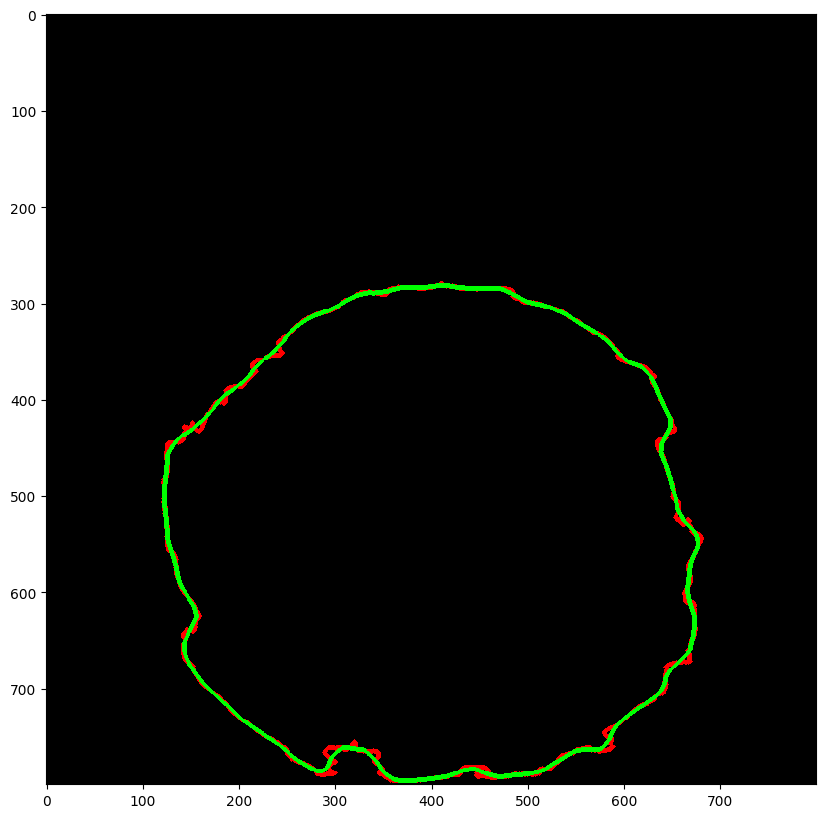

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(blank_image, interpolation='nearest')

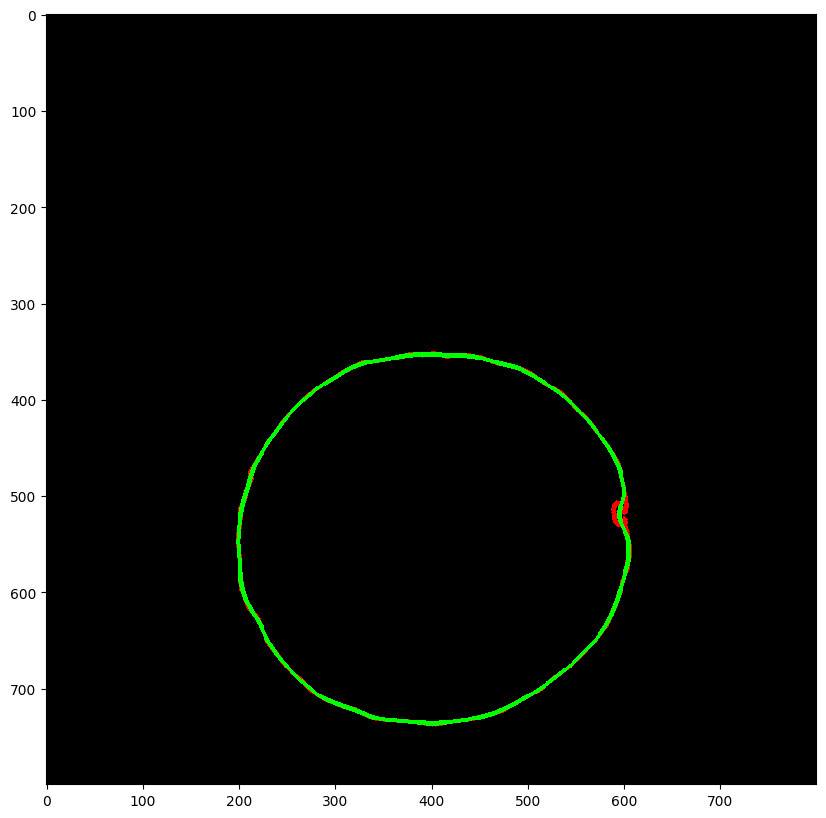

In [14]:
# Find contours in the smooth ragged image
contours_smooth, hierarchy_smooth = cv2.findContours(smooth_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find contours in the ragged image median
contours_median, hierarchy_median = cv2.findContours(smooth_image_median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image to draw the contours on
blank_image = np.zeros((800, 800, 3), dtype="uint8") 

# Draw contours from the smooth ragged image in red
cv2.drawContours(blank_image, contours_smooth, -1, (255,0,0), 3)

# Draw contours from the ragged image median in green
cv2.drawContours(blank_image, contours_median, -1, (0,255,0), 3)
plt.figure(figsize=(10, 10))
plt.imshow(blank_image, interpolation='nearest')

In [15]:
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix, recall_score

jaccard_score(ragged_image.astype(np.uint8).flatten(), (ragged_image_median/255).astype(np.uint8).flatten())

0.0

In [16]:
smooth_image_median.max()

1

In [18]:
import numpy as np
from scipy.interpolate import splprep, splev

def calculate_curvature(contour):
    # Get x and y coordinates
    x = contour[:, 0]
    y = contour[:, 1]

    # Fit a spline to the contour
    tck, u = splprep([x, y], s=0)

    # Get the first and second derivatives of the spline
    dx, dy = splev(u, tck, der=1)
    ddx, ddy = splev(u, tck, der=2)

    # Calculate curvature
    curvature = np.abs(dx * ddy - dy * ddx) / np.power(dx**2 + dy**2, 1.5)

    return curvature

In [20]:
np.mean(calculate_curvature(contours_smooth[0].squeeze()))

1.4467694406067444

In [21]:
contours_ragged, _ = cv2.findContours(ragged_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_smooth, _ = cv2.findContours(smooth_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [22]:
np.mean([np.mean(calculate_curvature(contour.squeeze())) for contour in contours_ragged])

1.8212189588670646

In [23]:
np.mean([np.mean(calculate_curvature(contour.squeeze())) for contour in contours_smooth])

1.4467694406067444

In [26]:
for mask in test_predictions_post:
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(np.var(calculate_curvature(contours[0].squeeze())))

1.234388567307751
1.1536690568542083
0.7332840818543925
0.7738063845206169
1.0107821540129447
0.6360723233750106
0.9188502916809645
41.306300859565745
31.515529328894456
19.62579161591816


In [27]:
test_images_timelapse = np.array([read_image(IMG_TIMELAPSE_PATH + folder + '/' + file) for file in test_fn_timelapse])


# # Predictions:
test_predictions = model.predict(test_images_timelapse, batch_size=8)

# # Post processing:
test_predictions_post = np.array([postprocessing(test_predictions[i, :, :, 0] > 0.5) for i in range(test_predictions.shape[0])])

23/23 [==============================] - 22s 1s/step


In [74]:
vars = []
area = []
means = []
for mask in test_predictions_post:
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    vars.append(np.var(calculate_curvature(contours[0].squeeze())))
    means.append(np.mean(calculate_curvature(contours[0].squeeze())))
    area.append(np.sum(mask))

In [47]:
# color gradient from blue to red
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, 10))

In [52]:
colors

array([[0.2298057 , 0.29871797, 0.75368315, 1.        ],
       [0.3634608 , 0.48478368, 0.90101889, 1.        ],
       [0.51082432, 0.64939661, 0.98507878, 1.        ],
       [0.66725292, 0.77917646, 0.99295921, 1.        ],
       [0.80496476, 0.85166616, 0.92616507, 1.        ],
       [0.91937599, 0.83127272, 0.78287363, 1.        ],
       [0.9682034 , 0.7208441 , 0.61229299, 1.        ],
       [0.94405457, 0.55315348, 0.43554849, 1.        ],
       [0.85237814, 0.34649195, 0.28034647, 1.        ],
       [0.70567316, 0.01555616, 0.15023281, 1.        ]])

In [51]:
np.array(vars)/np.max(vars)

array([9.07185038e-06, 3.42235321e-05, 6.90438078e-06, 8.37427754e-06,
       3.93604591e-05, 6.12362526e-05, 2.48905721e-04, 3.80394941e-05,
       1.20019077e-04, 2.90038270e-05, 5.90867492e-06, 6.67726552e-06,
       7.59868771e-06, 5.10638404e-06, 1.04858693e-05, 3.25032020e-05,
       3.10076074e-05, 3.68255008e-05, 3.78336828e-05, 8.50333657e-06,
       8.47862120e-06, 3.57623084e-05, 6.19298030e-06, 6.08553519e-06,
       7.79872132e-06, 3.88707850e-06, 5.17576314e-06, 7.83880619e-06,
       5.49084769e-06, 4.83939052e-06, 3.67168318e-05, 6.69718260e-06,
       5.97365850e-06, 5.09706363e-06, 4.53616440e-06, 5.44244022e-06,
       6.11627556e-06, 2.45977173e-05, 6.51783239e-06, 6.34180738e-06,
       5.38910004e-06, 7.39094487e-06, 5.83011912e-06, 5.09657907e-06,
       2.45291931e-05, 4.20871269e-05, 1.37966505e-05, 9.09410989e-06,
       7.32870938e-06, 5.96466857e-06, 6.89569926e-06, 6.70851648e-06,
       2.39846393e-05, 5.28401644e-06, 7.69896110e-06, 5.09005297e-05,
      

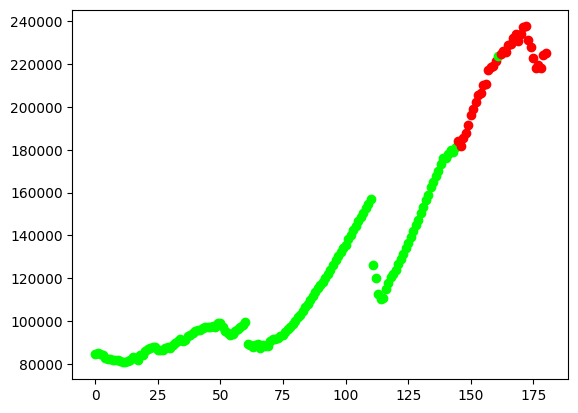

In [103]:
for i, a in enumerate(area):
    plt.scatter(i, a, color=[0, 1, 0] if moving_mean[i] < 25 else [1, 0, 0])

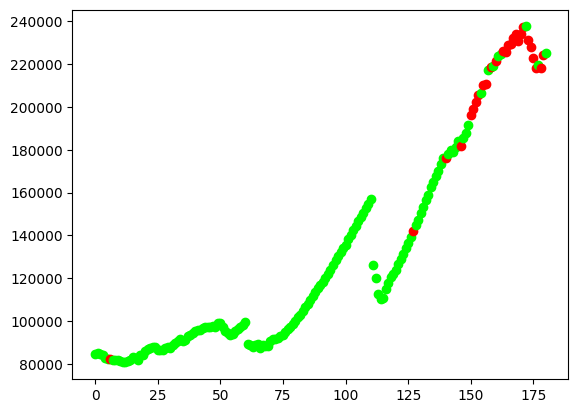

In [98]:
for i, a in enumerate(area):
    plt.scatter(i, a, color=[0, 1, 0] if vars[i] < 20 else [1, 0, 0])

In [101]:
# moving mean over variance:
moving_mean = np.convolve(vars, np.ones(4)/4, mode='same')

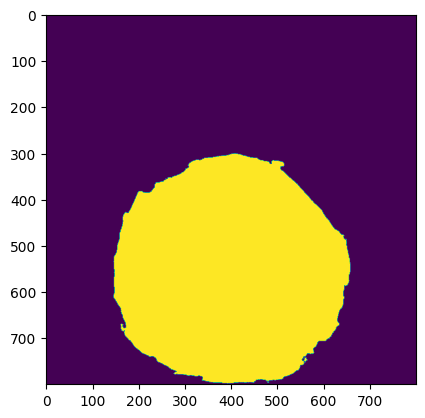

In [108]:
plt.imshow(test_predictions_post[150])

In [32]:
test_predictions_post.shape

(181, 800, 800)